<a href="https://colab.research.google.com/github/MariaCarolinass/analise-sinais/blob/main/sinaiscardiotocografia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados de cardiotocografia (CTG)

## Introdução e objetivos

A cardiotocografia (CTG) é um exame que avalia o bem-estar fetal através do registro da frequência cardíaca fetal e das contrações uterinas. Vamos estudar a relação entre a Frequência Cardíaca Fetal (FHR) e a Contração Uterina (UC). Os dados foram pegos do [CTU-CHB Intrapartum Cardiotocography Database](https://physionet.org/content/ctu-uhb-ctgdb/1.0.0/).

O database possuí uma colação de 552 CTGs da Universidade Técnica Tcheca, onde foram extraídos 9164 gravações coletadas no Hospital Universitário de Brno entre 2010 e 2012. Cada gravação tem até 90 minutos de duração e inclui uma série temporal de frequência cardíaca fetal, um sinal de contração uterina e detalhes clínicos maternos, de parto e do feto.

Critérios do database:

- Gravidez de Singleton
- Idade gestacional? 36 semanas
- Não há defeitos de desenvolvimento conhecidos a a priori
- Duração da fase 2 do trabalho de parto? 30 minutes
- Qualidade do sinal FHR (ou seja, porcentagem do registro durante o qual os dados de FHR estavam disponíveis) ? 50% em cada janela de 30 minutos
- Análise disponível dos parâmetros bioquímicos da amostra de sangue arterial umbilical (i.e. pH)
- Maioria dos partos vaginais (apenas 46 partos cesáreo (CS) incluídos)

Cada CTG contém uma série temporal de frequência cardíaca fetal (FCC) e um sinal de contração uterina (UC), cada um amostrado a 4 Hz.

In [1]:
!wget -r -N -c -np https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

A saída de streaming foi truncada nas últimas 5000 linhas.
Length: 84024 (82K) [application/octet-stream]
Saving to: ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1305.dat’

physionet.org/files 100%[===================>]  82.05K  --.-KB/s    in 0.1s    

2025-07-24 02:24:20 (743 KB/s) - ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1305.dat’ saved [84024/84024]

--2025-07-24 02:24:20--  https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1305.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 929 [text/plain]
Saving to: ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1305.hea’

physionet.org/files 100%[===================>]     929  --.-KB/s    in 0s      

2025-07-24 02:24:20 (374 MB/s) - ‘physionet.org/files/ctu-uhb-ctgdb/1.0.0/1305.hea’ saved [929/929]

--2025-07-24 02:24:20--  https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/1306.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 62400 (61

In [2]:
!pip install pandas
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [3]:
%cd /content/physionet.org/files/ctu-uhb-ctgdb/1.0.0/

/content/physionet.org/files/ctu-uhb-ctgdb/1.0.0


In [4]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from scipy import signal

## Exploração, visualização e descrição dos sinais

In [5]:
# carregar registro
record = wfdb.rdrecord("1001")
print("Canais disponíveis:", record.sig_name)

Canais disponíveis: ['FHR', 'UC']


In [6]:
# parâmetros adicionais
for comment in record.comments:
  print(comment)

----- Additional parameters for record 1001
-- Outcome measures
pH           7.14
BDecf        8.14
pCO2         7.7
BE           -10.5
Apgar1       6
Apgar5       8
-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!
NICU days    0
Seizures     0
HIE          0
Intubation   0
Main diag.   0
Other diag.  0
-- Fetus/Neonate descriptors
Gest. weeks  37
Weight(g)    2660
Sex          2
-- Maternal (risk-)factors
Age          32
Gravidity    1
Parity       0
Diabetes     1
Hypertension 0
Preeclampsia 0
Liq. praecox 1
Pyrexia      0
Meconium     0
-- Delivery descriptors
Presentation 2
Induced      0
I.stage      232
NoProgress   0
CK/KP        0
II.stage     20
Deliv. type  1
-- Signal information
dbID         974204
Rec. type    1
Pos. II.st.  14400
Sig2Birth    0


In [12]:
# extrair sinais
signals = record.p_signal
fhr = signals[:, 0].astype(float)
uc = signals[:, 1].astype(float)
fs = record.fs # frequência de amostragem (4 Hz)

# Trocar valores negativos com NaN
fhr[fhr < 0] = np.nan
uc[uc < 0] = np.nan

# eixo de tempo
time = np.arange(len(fhr)) / fs  # tempo em segundos

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=fhr, mode='lines', name='FHR'))
fig.add_trace(go.Scatter(x=time, y=uc, mode='lines', name='UC'))
fig.update_layout(title='Frequência Cardíaca Fetal (FHR) X Contração Uterina (UC)', xaxis_title='Tempo (s)', yaxis_title='Valores')
fig.show()

- O sinal de FHR apresentou variações características com valores ausentes ou nulos em alguns trechos.

- O sinal de UC apresentou picos regulares ao longo do tempo, indicando contrações uterinas bem definidas.

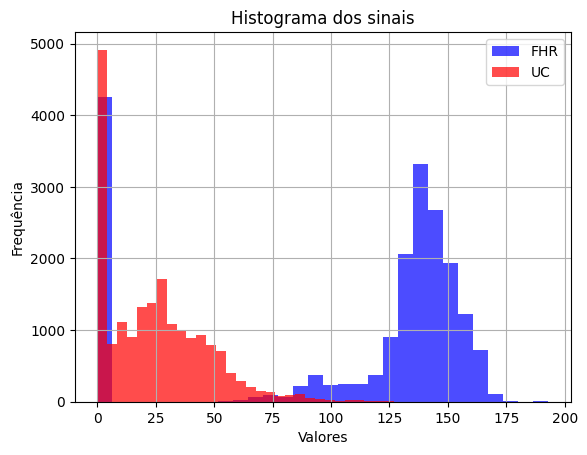

In [13]:
plt.hist(fhr, bins=30, color='blue', alpha=0.7, label='FHR')
plt.hist(uc, bins=30, color='red', alpha=0.7, label='UC')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Histograma dos sinais')
plt.legend()
plt.grid()
plt.show()

- A FHR apresentou uma distribuição concentrada em torno de 100 a 150 bpm por segundo, indicando uma variação normal.

- A UC mostrou uma alta frequência com valores próximos de zero, representando altos picos de contrações.

- A FHR aparenta ter uma distribuição mais estável em relação a UC.

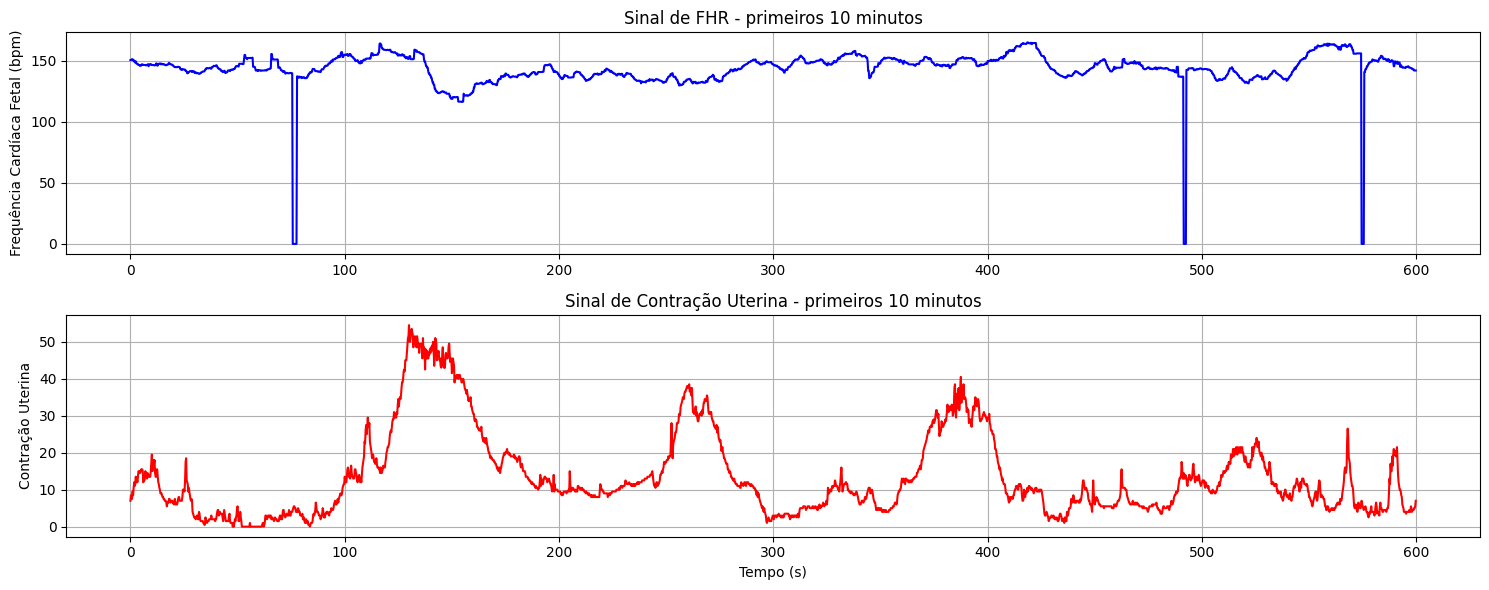

In [14]:
# Plotando os dois sinais em janelas de tempo
limite = 10 * 60 * fs  # 10 minutos

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time[:int(limite)], fhr[:int(limite)], label='FHR', color='blue')
plt.ylabel('Frequência Cardíaca Fetal (bpm)')
plt.title('Sinal de FHR - primeiros 10 minutos')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time[:int(limite)], uc[:int(limite)], label='UC', color='red')
plt.ylabel('Contração Uterina')
plt.xlabel('Tempo (s)')
plt.title('Sinal de Contração Uterina - primeiros 10 minutos')
plt.grid()

plt.tight_layout()
plt.show()

Em alguns momentos houve perca de sinal FHR, sinal nulo (possível erro no equipamento), já o sinal UC com alguns períodos sem grandes variações, intercalando com altos picos de atividade.

## Pré-processamento dos sinais

In [15]:
# dados estatísticos
stats = {
    'Sinal': ['FHR', 'UC'],
    'Média': [np.mean(fhr), np.mean(uc)],
    'Mediana': [np.median(fhr), np.median(uc)],
    'Desvio Padrão': [np.std(fhr), np.std(uc)],
    'Mínimo': [np.min(fhr), np.min(uc)],
    'Máximo': [np.max(fhr), np.max(uc)],
}

df_stats = pd.DataFrame(stats)
df_stats

,Sinal,Média,Mediana,Desvio Padrão,Mínimo,Máximo
0,FHR,106.984336,136.25,59.376698,0.0,193.0
1,UC,24.815130,23.00,21.970835,0.0,127.0


In [16]:
# janela gaussiana
kernel = signal.windows.gaussian(136, std=59)
kernel = kernel / np.sum(kernel)

# aplicando suavização no sinal
fhr_w = signal.convolve(fhr, kernel, mode='same')
fhr_med = signal.medfilt(fhr, kernel_size=11) # mediana móvel
fhr_suave = signal.convolve(fhr_med, kernel, mode='same') # convolução

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=fhr, name='Original'))
fig.add_trace(go.Scatter(x=time, y=fhr_w, name='Sem mediana móvel'))
fig.add_trace(go.Scatter(x=time, y=fhr_suave, name='Com mediana móvel e convolução'))
fig.update_layout(title='FHR', xaxis_title='Tempo (s)', yaxis_title='Valores' )
fig.show()

In [17]:
kernel = signal.windows.gaussian(23, std=22)
kernel = kernel / np.sum(kernel)

uc_w = signal.convolve(uc, kernel, mode='same')
uc_med = signal.medfilt(uc, kernel_size=11) # mediana móvel
uc_suave = signal.convolve(uc_med, kernel, mode='same') # convolução

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=uc, name='Original'))
fig.add_trace(go.Scatter(x=time, y=uc_w, name='Sem mediana móvel'))
fig.add_trace(go.Scatter(x=time, y=uc_suave, name='Com mediana móvel e convolução'))
fig.update_layout(title='UC', xaxis_title='Tempo (s)', yaxis_title='Valores' )
fig.show()

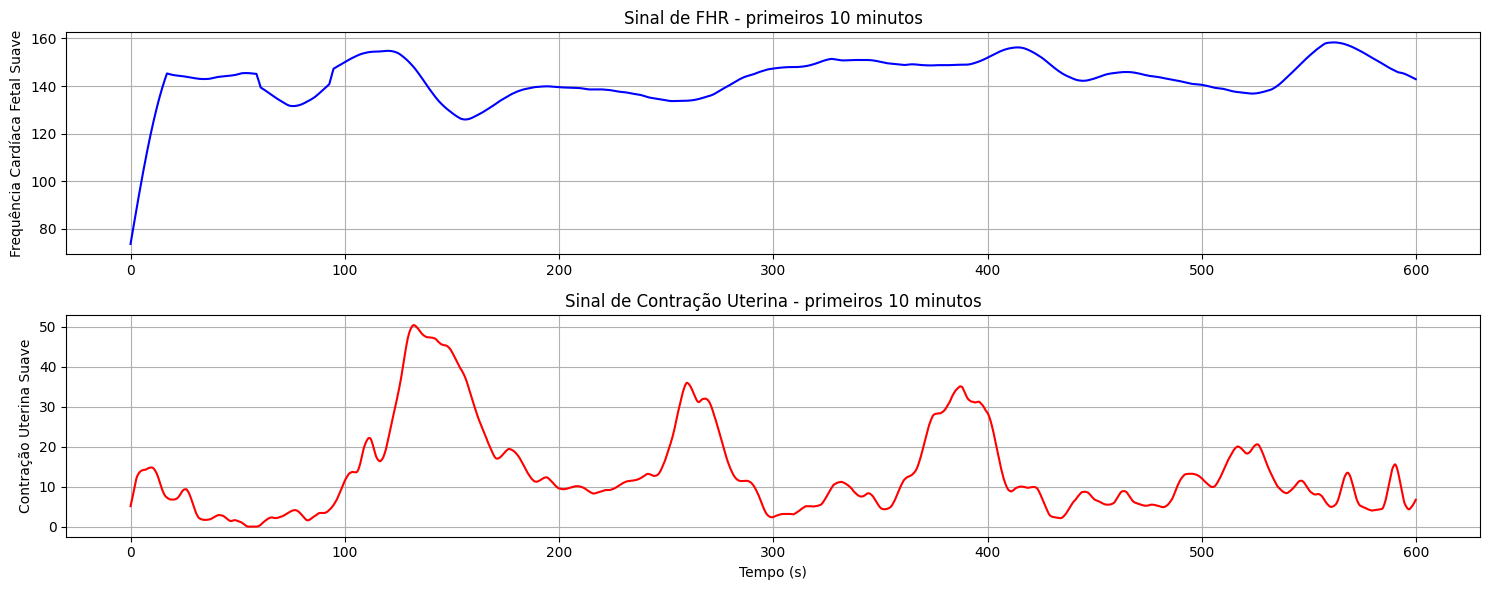

In [18]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time[:int(limite)], fhr_suave[:int(limite)], label='FHR', color='blue')
plt.ylabel('Frequência Cardíaca Fetal Suave')
plt.title('Sinal de FHR - primeiros 10 minutos')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time[:int(limite)], uc_suave[:int(limite)], label='UC', color='red')
plt.ylabel('Contração Uterina Suave')
plt.xlabel('Tempo (s)')
plt.title('Sinal de Contração Uterina - primeiros 10 minutos')
plt.grid()

plt.tight_layout()
plt.show()

Os sinais foram suavizados removendo pequenos ruídos.

## Análise dos sinais

In [20]:
# Análise espectral com Welch
f_fhr, psd_fhr = signal.welch(fhr_suave, fs, nperseg=4096)
f_uc, psd_uc = signal.welch(uc_suave, fs, nperseg=4096)

# Frequência dominante (pico do espectro)
freq_dom_fhr = f_fhr[np.argmax(psd_fhr)]
freq_dom_uc = f_uc[np.argmax(psd_uc)]

print(f"Frequência dominante FHR: {freq_dom_fhr:.4f} Hz ({freq_dom_fhr*60:.2f} bpm)")
print(f"Frequência dominante UC: {freq_dom_uc:.4f} Hz ({freq_dom_uc*60:.2f} ciclos por minuto)")

Frequência dominante FHR: 0.0088 Hz (0.53 bpm)
Frequência dominante UC: 0.0010 Hz (0.06 ciclos por minuto)


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=f_fhr, y=psd_fhr, mode='lines', name='FHR'))
fig.add_trace(go.Scatter(x=f_uc, y=psd_uc, mode='lines', name='UC'))
fig.update_layout(title='Análise espectral (Welch) - FHR e UC', xaxis_title='Frequência (Hz)', yaxis_title='Densidade espectral (PSD)')
fig.show()

A frenquência dominante FHR indicou oscilações lentas em torno do ritmo cardíaco fetal. A UC ainda mais baixa, na qual confirma que houve oscilações entre os períodos de baixa e alta contração.

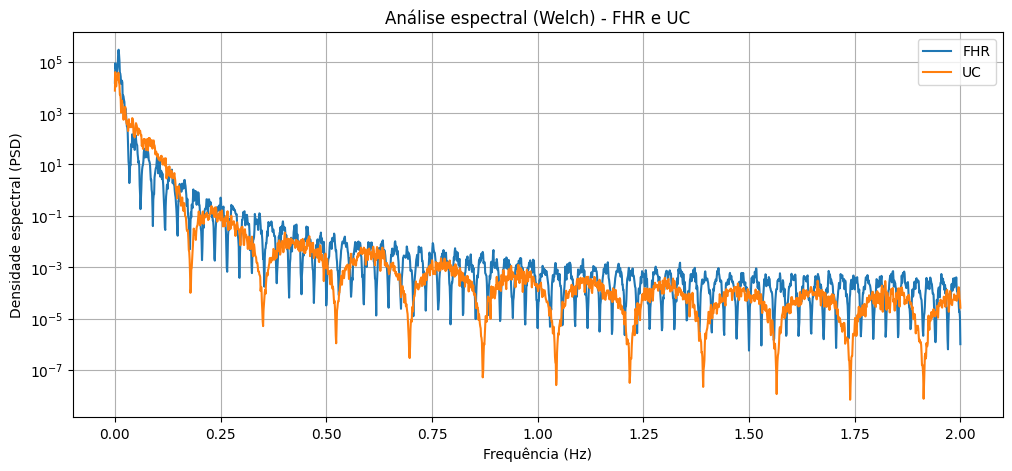

In [22]:
plt.figure(figsize=(12, 5))
plt.semilogy(f_fhr, psd_fhr, label='FHR')
plt.semilogy(f_uc, psd_uc, label='UC')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Densidade espectral (PSD)')
plt.title('Análise espectral (Welch) - FHR e UC')
plt.grid()
plt.legend()
plt.show()

Maior concentração FHR e UC em frequências baixas.

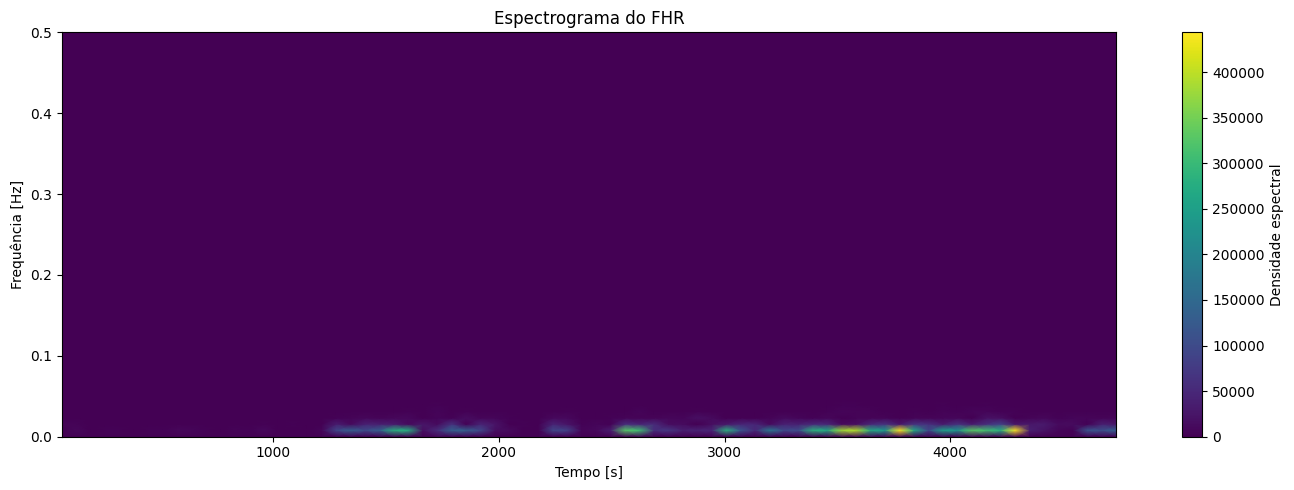

In [23]:
# Espectrograma do FHR
f_spec, t_spec, Sxx = signal.spectrogram(fhr_suave, fs=fs, nperseg=512, noverlap=256)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_spec, f_spec, Sxx, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.title('Espectrograma do FHR')
plt.colorbar(label='Densidade espectral')
plt.ylim(0, 0.5)  # limitar a faixa útil
plt.tight_layout()
plt.show()

O espectograma mostrou uma distribuição da densidade de concentração em baixas frequências.

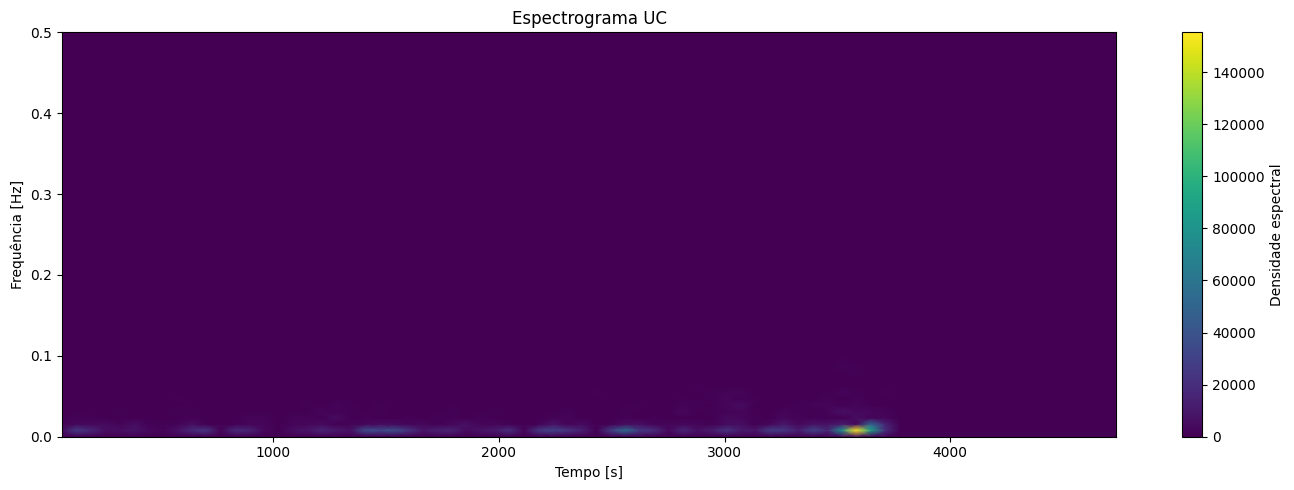

In [24]:
# Espectrograma UC
f_spec, t_spec, Sxx = signal.spectrogram(uc_suave, fs=fs, nperseg=512, noverlap=256)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_spec, f_spec, Sxx, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.title('Espectrograma UC')
plt.colorbar(label='Densidade espectral')
plt.ylim(0, 0.5)  # limitar a faixa útil
plt.tight_layout()
plt.show()

In [25]:
# Intervalo entre contrações uterinas
peaks, _ = signal.find_peaks(uc_suave, height=1.5, distance=fs*30)

tempos = peaks / fs  # em segundos
intervalos = np.diff(tempos)

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=uc, mode='lines', name='UC'))
fig.add_trace(go.Scatter(x=tempos, y=intervalos, mode='markers', name='Peaks'))
fig.update_layout(title='UC', xaxis_title='Tempo (s)', yaxis_title='Valores')
fig.show()

A frequência das contrações aumenta gradualmente ao longo do tempo com alguns picos com maior intensidade. Possívelmente o sinal revela que a paciente está entrando em trabalho de parto.

## Conclusões

A análise dos sinais de frequência cardíaca fetal (FHR) e contrações uterinas (UC) nos ajudou a entender melhor como esses sinais se comportam ao longo do tempo, desde a primeira visualização até a extração de informações importantes, tanto no domínio do tempo quanto no espectro. Após o pré-processamento com filtros como janela gaussiana, média móvel e convolução, foi possível remover ruídos e realçar os padrões fisiológicos presentes nos dados.

Ao usar o método de Welch para análise espectral, identificamos frequências dominantes. O FHR apresentando maior atividade por volta de 0,0088 Hz e o UC em cerca de 0,0010 Hz. O espectrograma mostrou que a maior energia do FHR está concentrada nas baixas frequências. Além disso, ao detectar os picos nas contrações uterinas, conseguimos medir os intervalos entre elas, oferecendo uma visão mais clara do ritmo e da intensidade dessas contrações.